In [207]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

from ..src import View

TARGET_IMG = 'images/rainy.jpg'
SRC_IMG = 'images/road.jpg'
IMG_SIZE = (640, 640)

In [208]:
# read in the images
target_img = cv2.imread(TARGET_IMG)
src_img = cv2.imread(SRC_IMG)

# conver to rgb
target_img = cv2.cvtColor(target_img, cv2.COLOR_BGR2RGB)
src_img = cv2.cvtColor(src_img, cv2.COLOR_BGR2RGB)

# resize to IMG_SIZE
target_img = cv2.resize(target_img, IMG_SIZE)
src_img = cv2.resize(src_img, IMG_SIZE)

<Figure size 1000x600 with 0 Axes>

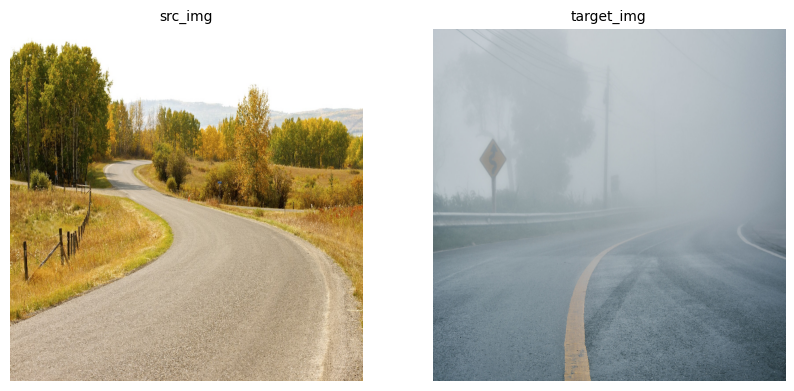

In [209]:
# plot the images
View.compare_color(np.stack([src_img, target_img]), labels=['src_img', 'target_img'], label_cols=True)

In [210]:
def calc_hist(img:np.ndarray) -> np.ndarray:
    hist = np.zeros(shape=(256), dtype=np.uint64)
    for x in range(img.shape[0]):
        for y in range(img.shape[1]):
            hist[img[x, y]] += 1
    return hist

In [211]:
# convert images to hsv
target_img_hsv = cv2.cvtColor(target_img, cv2.COLOR_RGB2HSV)
src_img_hsv = cv2.cvtColor(src_img, cv2.COLOR_RGB2HSV)

In [212]:
def hist_remap_lut(img:np.ndarray, hist:np.ndarray) -> np.ndarray:
    lut = np.zeros(shape=(256), dtype=np.uint8)
    
    # first get the histogram of the image
    img_hist = calc_hist(img)
    hist = hist.astype(np.int64)
    img_hist = img_hist.astype(np.int64)
    
    hist_idx = np.nonzero(hist)[0][0]
    lut_idx = 0
    diff = 0
    
    while(lut_idx < 256 and hist_idx < 256):       
        
        # get difference between the two histograms
        diff = hist[hist_idx] - img_hist[lut_idx] + diff
        # print(f'hist_idx: {hist_idx}, lut_idx: {lut_idx}, diff: {diff}'
        
        lut[lut_idx] = hist_idx
        
        if diff < 0:
            diff = diff + img_hist[lut_idx]
            hist_idx += 1
        
            # print(f'Fast forward hist_idx to {i}, new diff: {diff}')
        elif diff > 0:
            diff = diff - hist[hist_idx]
            lut_idx += 1
        
        else:
            hist_idx += 1
            lut_idx += 1   

    if hist_idx >= 255:
        lut[lut_idx:] = 255
    else:
        lut[lut_idx:] = hist_idx
        
    # apply lut to new image
    new_img = img.copy()
    for x in range(img.shape[0]):
        for y in range(img.shape[1]):
            new_img[x, y] = lut[new_img[x, y]]
            
            
    return new_img, lut

In [213]:
# create normalized bell curve

def bell_curve_hist(mu, sigma, num_pixels) -> np.ndarray:
    t = np.arange(0, 256, dtype=np.float64)
    bell = np.exp(-np.power(t - mu, 2.) / (2 * np.power(sigma, 2.))) * (1 / (sigma * np.sqrt(2 * np.pi)))
    bell *= num_pixels / np.sum(bell)
    bell = bell.astype(np.uint64)
    
    # this is imperfect, but the resulting histogram must have the number of pixels in the image
    for i in range(0, int(num_pixels - np.sum(bell))):
        bell[-i] += 1
        
    return bell

In [214]:
# get histogram of the target_img image
target_img_hist = calc_hist(target_img_hsv[:, :, 2])
src_img_hist = calc_hist(src_img_hsv[:, :, 2])

num_pixels = IMG_SIZE[0] * IMG_SIZE[1]

bell = bell_curve_hist(np.mean(target_img_hsv[:, :, 2]), np.std(target_img_hsv[:, :, 2]), num_pixels)

print(f'bell sum: {np.sum(bell)}')
print(f'mean: {np.mean(np.mean(target_img_hsv[:, :, 2]))}, std: {np.std(target_img_hsv[:, :, 2])}')

plt.figure(figsize=(6, 2))
plt.plot(target_img_hist)
plt.title('Target Hist')

plt.figure(figsize=(6, 2))
plt.plot(bell)
plt.title('Equivelent Bell')

plt.figure(figsize=(6, 2))
plt.plot(src_img_hist)
plt.title('src_img Hist')


#apply histogram remapping to the src_img image
remapped_src_img_hsv = src_img_hsv.copy()
remapped_src_img_hsv[:,:,2], lut = hist_remap_lut(src_img_hsv[:, :, 2], target_img_hist)

plt.figure(figsize=(6, 2))
plt.plot(lut)
plt.title('Remapping Lut')

plt.figure(figsize=(6, 2))
plt.plot(calc_hist(remapped_src_img_hsv[:, :, 2]))
plt.title('Remapped img')


plt.show()

<Figure size 1000x600 with 0 Axes>

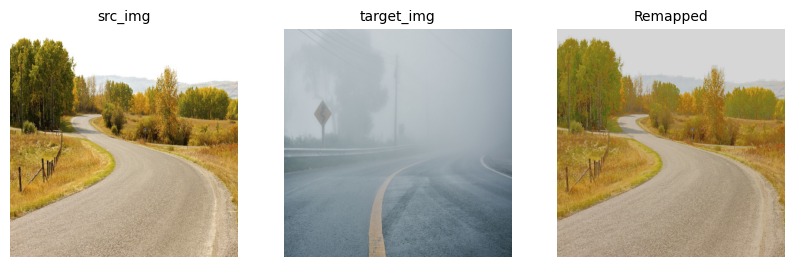

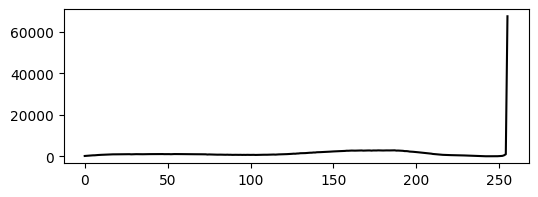

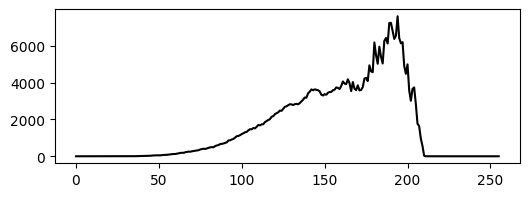

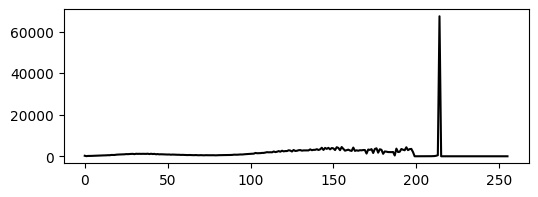

In [ ]:
# convert back to rgb
remapped_src_img = cv2.cvtColor(remapped_src_img_hsv, cv2.COLOR_HSV2RGB)

# plot the images
View.compare_color(np.stack([src_img, target_img, remapped_src_img]), labels=['src_img', 'target_img', 'Remapped'], label_cols=True)

#plot histogram of the images
View.histogram(np.stack([src_img, target_img, remapped_src_img]), figsize=(6, 2), show_rgb=False)